# Initial data exploration

In this notebook I am going to load the data, create useful insights about it and based upon this create scripts for data preprocessing and model training

> Note: before running this notebook, it is important to download the data (please, refer to corresponding [README](../data/README.md))

## Loading the data

In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette("Set2")
np.random.seed(42)

Reading genres from corresponding file

In [2]:
genres = []

with open("../data/raw/ml-100k/u.genre") as genres_file:
    for genre in genres_file.readlines():
        # check for emptiness
        if genre.strip():
            genres.append(genre.split("|")[0])

pprint(genres)
assert len(genres) == 19, "number of genres including unknown should be 19"

['unknown',
 'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']


Creating dataframes

> created special function to quckly write column names 

`user id | age | gender | occupation | zip code`

`->`

`["user_id", "age", "gender", "occupation", "zip_code"]`

```python
lambda x: "[" + ", ".join([f'"{el.strip().replace(" ", "_")}"' for el in x.split("|")]) + "]"
```

In [3]:
users_df = pd.read_csv(
    "../data/raw/ml-100k/u.user",
    sep="|",
    header=None,
    names=["user_id", "age", "gender", "occupation", "zip_code"],
    index_col="user_id",
)
items_df = pd.read_csv(
    "../data/raw/ml-100k/u.item",
    sep="|",
    # there was some problem with utf-8, solved according to the stackoverflow answer
    # https://stackoverflow.com/questions/5552555/unicodedecodeerror-invalid-continuation-byte
    encoding="latin-1",
    header=None,
    names=[
        "movie_id",
        "movie_title",
        "release_date",
        "video_release_date",
        "IMDb_URL",
    ]
    + genres,
    index_col="movie_id",
)
users_to_items_df = pd.read_csv(
    "../data/raw/ml-100k/u.data",
    sep="\t",
    header=None,
    names=["user_id", "item_id", "rating", "timestamp"],
)
# for viewing pleasure
users_to_items_df["timestamp"] = pd.to_datetime(
    users_to_items_df["timestamp"],
    unit="s",
)

In [4]:
users_df.head()

,age,gender,occupation,zip_code
user_id,,,,
1,24,M,technician,85711
2,53,F,other,94043
3,23,M,writer,32067
4,24,M,technician,43537
5,33,F,other,15213


In [5]:
items_df.head()

,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
users_to_items_df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16


Now, let's join the data together

In [7]:
joined_df = users_to_items_df.join(other=users_df).join(other=items_df)
joined_df.head()

,user_id,item_id,rating,timestamp,age,gender,occupation,zip_code,movie_title,release_date,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,1997-12-04 15:55:49,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,186,302,3,1998-04-04 19:22:22,24.0,M,technician,85711,Toy Story (1995),01-Jan-1995,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,22,377,1,1997-11-07 07:18:36,53.0,F,other,94043,GoldenEye (1995),01-Jan-1995,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,244,51,2,1997-11-27 05:02:03,23.0,M,writer,32067,Four Rooms (1995),01-Jan-1995,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,166,346,1,1998-02-02 05:33:16,24.0,M,technician,43537,Get Shorty (1995),01-Jan-1995,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Exploration

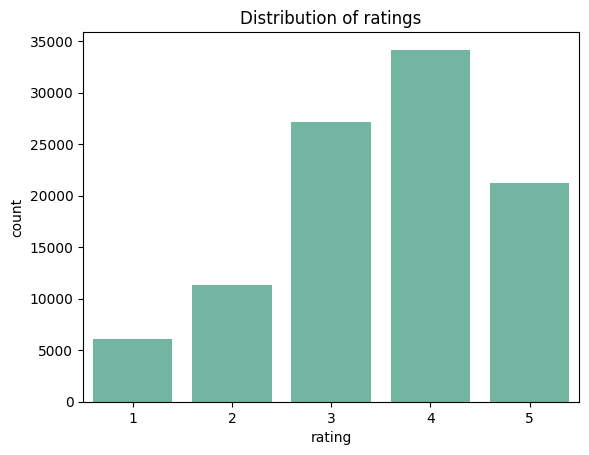

In [8]:
sns.countplot(x="rating", data=users_to_items_df)
plt.title("Distribution of ratings")
plt.show()

So the most popular rating is 4.0

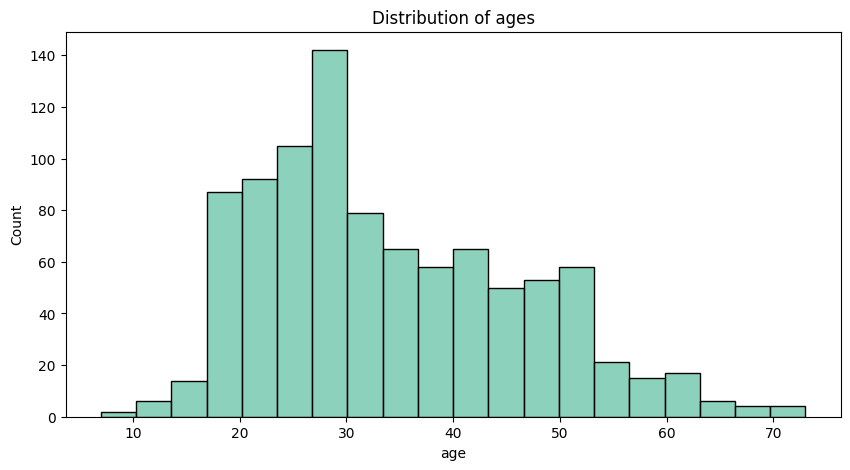

In [9]:
plt.figure(figsize=(10, 5))
sns.histplot(x="age", data=users_df, bins=20)
plt.title("Distribution of ages")
plt.show()

People of age 20-40 are the most active

In [10]:
users_df.head()

,age,gender,occupation,zip_code
user_id,,,,
1,24,M,technician,85711
2,53,F,other,94043
3,23,M,writer,32067
4,24,M,technician,43537
5,33,F,other,15213


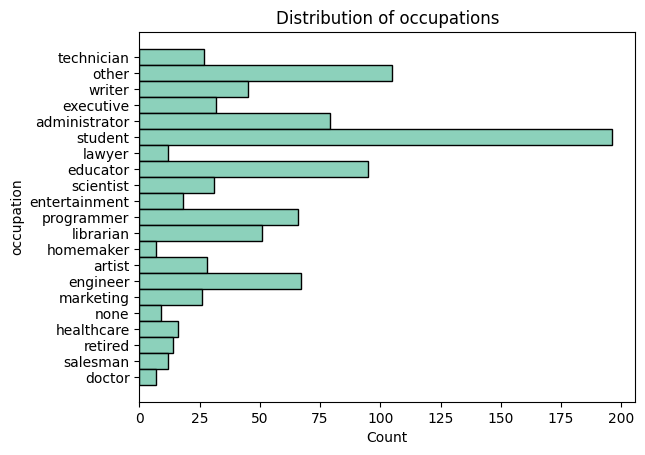

In [11]:
plt.title("Distribution of occupations")
sns.histplot(y="occupation", data=users_df)
plt.show()

Most popular occupation is student

In [12]:
popularity = (
    users_to_items_df.groupby("item_id")
    .count()
    .sort_values("rating", ascending=False)
    .join(other=items_df, how="left")[["movie_title", "user_id"]]
    .rename(columns={"user_id": "number_of_ratings"})
)

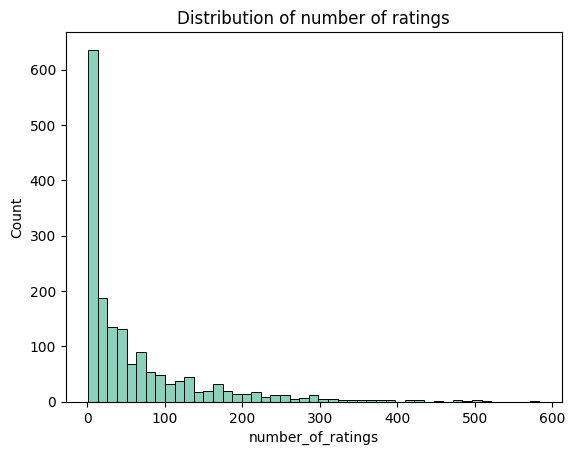

In [13]:
sns.histplot(x="number_of_ratings", data=popularity.sort_values("number_of_ratings"))
plt.title("Distribution of number of ratings")
plt.show()

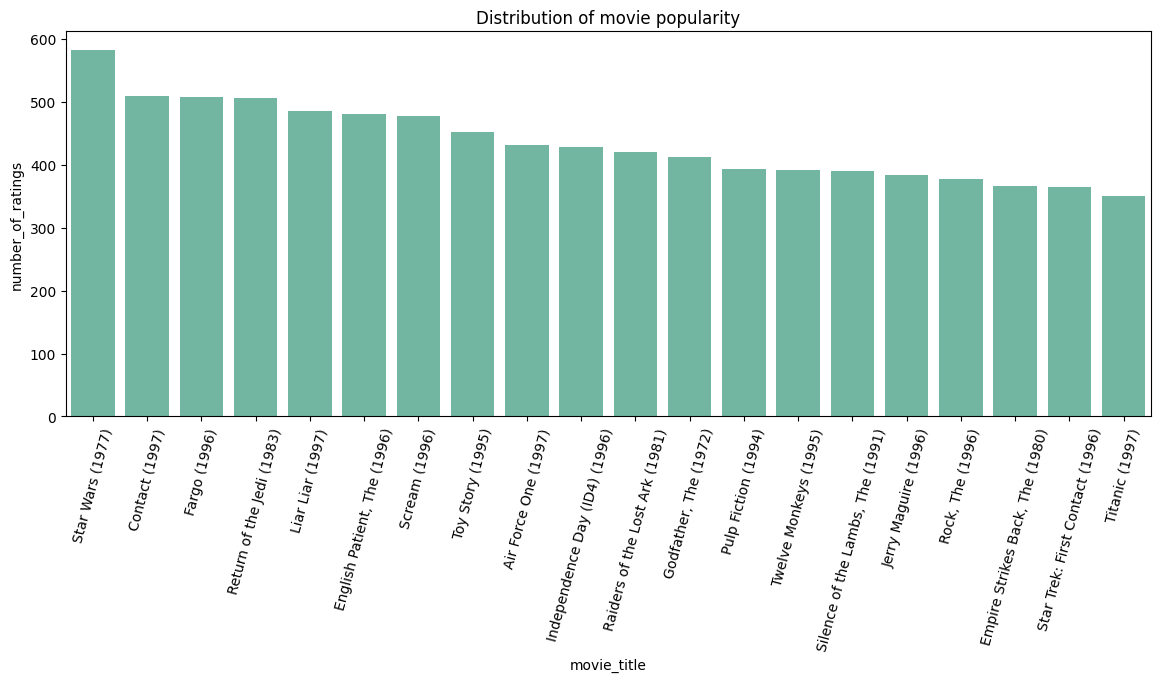

In [14]:
plt.figure(figsize=(14, 5))
sns.barplot(x="movie_title", y="number_of_ratings", data=popularity.head(20))
plt.title("Distribution of movie popularity")
plt.xticks(rotation=75)
plt.show()

## Conclusion

So, we have 943 users, 1682 movies and 100000 ratings

The dataset don't seem to have any problems, so I don't see anything what I want to process in it. Instead, I am just going to train test split it myself and then use it for training

Additionally, while the user and movie information might be useful, I am not going to use for simplicity

For further instructions, please, refer to [README](../data/README.md)